In [12]:
import spotpy
import math
import pandas as pd
import numpy as np
from numpy import tanh
import matplotlib.pylab as plt

In [2]:
input_data = pd.read_csv("../data/gr4j/data_gr4j.csv")

In [3]:
input_data.head()

,Rainfall\t,Evaporation,Discharge
0,0,0,0.51
1,0,0,0.50
2,0,0,0.48
3,0,0,0.47
4,0,0,0.45


Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  10000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'sceua_gr4j.csv' created.
39 of 10000, minimal objective function=1941.32, time remaining: 00:08:21
79 of 10000, minimal objective function=1663.45, time remaining: 00:08:23
122 of 10000, minimal objective function=1663.45, time remaining: 00:08:08
165 of 10000, minimal objective function=1663.45, time remaining: 00:08:00
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
215 of 10000, minimal objective function=1663.45, time remaining: 00:07:40
301 of 10000, minimal objective function=1663.45, time remaining: 00:06:42
391 of 10000, minimal objective function=1160.22, time remaining: 00:06:10
476 of 10000, minimal objective function=1160.22, time remaining: 00:05:48
561 of 10000, minimal objective f

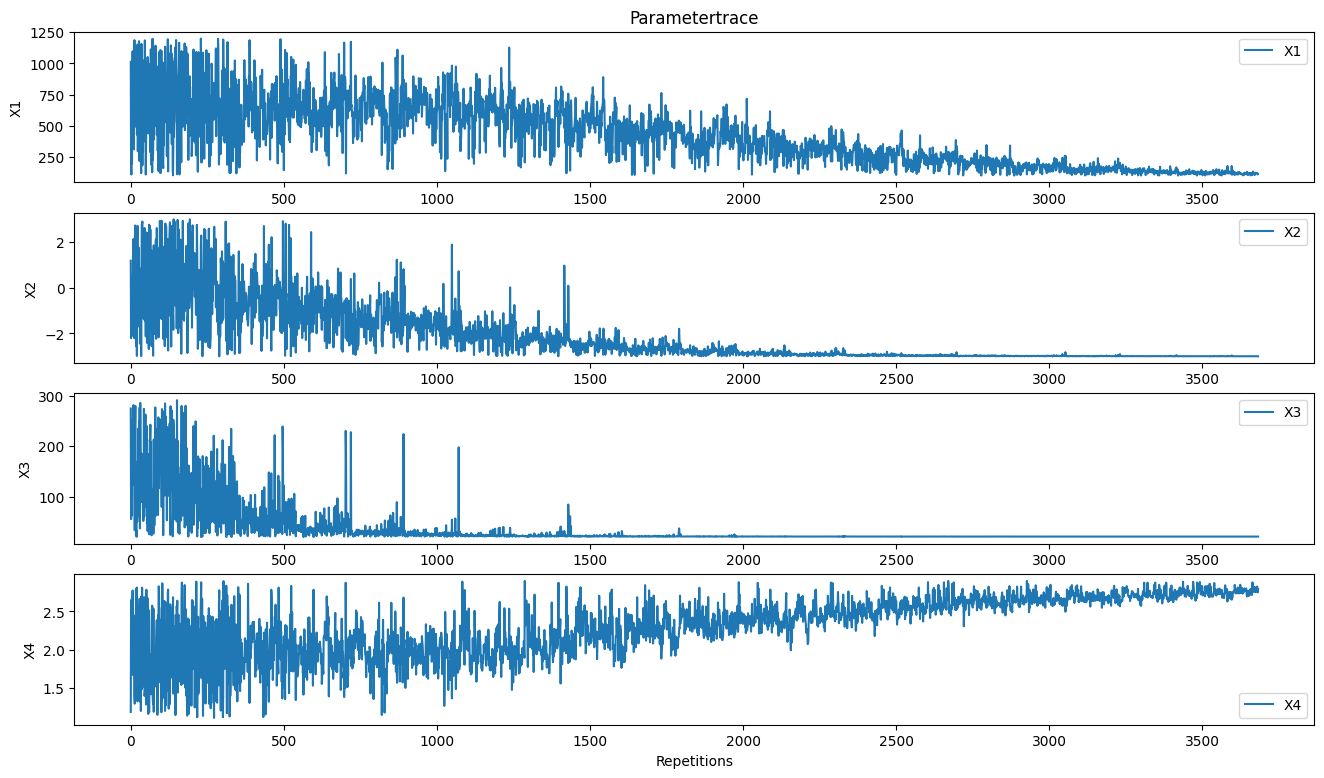

In [8]:
def s_curves1(t, x4):
    """
        Unit hydrograph ordinates for UH1 derived from S-curves.
    """

    if t <= 0:
        return 0
    elif t < x4:
        return (t/x4)**2.5
    else: # t >= x4
        return 1


def s_curves2(t, x4):
    """
        Unit hydrograph ordinates for UH2 derived from S-curves.
    """

    if t <= 0:
        return 0
    elif t < x4:
        return 0.5*(t/x4)**2.5
    elif t < 2*x4:
        return 1 - 0.5*(2 - t/x4)**2.5
    else: # t >= x4
        return 1

def gr4j(X1, X2, X3, X4):
    input_data = pd.read_csv("../data/gr4j/data_gr4j.csv")

    states = {'production_store': 0.60 * X1, 'routing_store': 0.70 * X3}
    qsim = []

    for i in range(0, len(input_data)):
        precip = input_data.iloc[i, 0]
        potential_evap = input_data.iloc[i, 1]
        catchment_size = 2965  # km^2

        nUH1 = int(math.ceil(X4))
        nUH2 = int(math.ceil(2.0 * X4))

        uh1_ordinates = [0] * nUH1
        uh2_ordinates = [0] * nUH2

        UH1 = states.get('UH1', [0] * nUH1)
        UH2 = states.get('UH2', [0] * nUH2)

        for t in range(1, nUH1 + 1):
            uh1_ordinates[t - 1] = s_curves1(t, X4) - s_curves1(t - 1, X4)

        for t in range(1, nUH2 + 1):
            uh2_ordinates[t - 1] = s_curves2(t, X4) - s_curves2(t - 1, X4)

        production_store = states.get('production_store', 0)  # S
        routing_store = states.get('routing_store', 0)  # R

        if precip > potential_evap:
            net_evap = 0
            scaled_net_precip = (precip - potential_evap) / X1
            if scaled_net_precip > 13:
                scaled_net_precip = 13.
            tanh_scaled_net_precip = tanh(scaled_net_precip)
            reservoir_production = (X1 * (1 - (production_store / X1) ** 2) * tanh_scaled_net_precip) / (
                        1 + production_store / X1 * tanh_scaled_net_precip)
            routing_pattern = precip - potential_evap - reservoir_production
        else:
            scaled_net_evap = (potential_evap - precip) / X1
            if scaled_net_evap > 13:
                scaled_net_evap = 13.
            tanh_scaled_net_evap = tanh(scaled_net_evap)
            ps_div_x1 = (2 - production_store / X1) * tanh_scaled_net_evap
            net_evap = production_store * (ps_div_x1) / \
                       (1 + (1 - production_store / X1) * tanh_scaled_net_evap)
            reservoir_production = 0
            routing_pattern = 0

        production_store = production_store - net_evap + reservoir_production
        percolation = production_store / (1 + (production_store / 2.25 / X1) ** 4) ** 0.25
        routing_pattern = routing_pattern + (production_store - percolation)
        production_store = percolation

        for i in range(0, len(UH1) - 1):
            UH1[i] = UH1[i + 1] + uh1_ordinates[i] * routing_pattern
        UH1[-1] = uh1_ordinates[-1] * routing_pattern

        for j in range(0, len(UH2) - 1):
            UH2[j] = UH2[j + 1] + uh2_ordinates[j] * routing_pattern
        UH2[-1] = uh2_ordinates[-1] * routing_pattern

        groundwater_exchange = X2 * (routing_store / X3) ** 3.5
        routing_store = max(0, routing_store + UH1[0] * 0.9 + groundwater_exchange)

        R2 = routing_store / (1 + (routing_store / X3) ** 4) ** 0.25
        QR = routing_store - R2
        routing_store = R2
        QD = max(0, UH2[0] * 0.1 + groundwater_exchange)
        Q = QR + QD

        qsim.append(Q * catchment_size)

    return qsim


class Setup(object):

    def __init__(self):
        self.params = [
            spotpy.parameter.Uniform('X1', low=100, high=1200, optguess=354),
            spotpy.parameter.Uniform('X2', low=-3, high=3, optguess=0),
            spotpy.parameter.Uniform('X3', low=20, high=300, optguess=90),
            spotpy.parameter.Uniform('X4', low=1.1, high=2.9, optguess=1.7)
        ]
        self.observations = input_data.iloc[:, 2].tolist()

    def parameters(self):
        return spotpy.parameter.generate(self.params)

    def simulation(self, vector):
        simulations = gr4j(vector[0], vector[1], vector[2], vector[3])
        return simulations

    def evaluation(self):
        return self.observations

    def objectivefunction(self, simulation, evaluation):
        objectivefunction = -spotpy.objectivefunctions.nashsutcliffe(evaluation=evaluation, simulation=simulation)
        return objectivefunction


setup = Setup()
sampler = spotpy.algorithms.sceua(setup, dbname='sceua_gr4j', dbformat='csv')
sampler.sample(10000)

results = sampler.getdata()
spotpy.analyser.plot_parametertrace(results)
     



In [9]:
simulacion = gr4j(X1=103.123, X2=-2.99955, X3=21.1014, X4=2.79007)

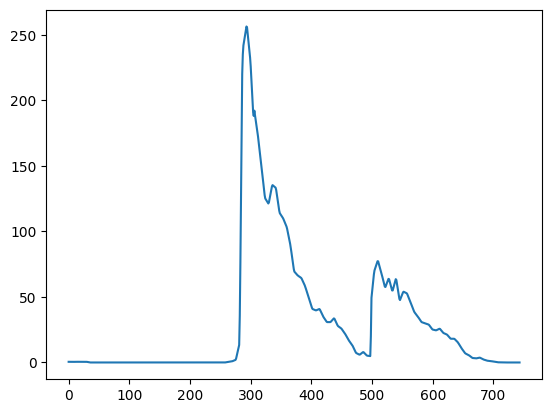

In [13]:
plt.plot(input_data.Discharge)